<a id='toc'></a>
# Отчет по запланированным поездам

1. [Проверка планирования всех реальных поездов](#all_plan)
1. [Проверка совпадения четности номеров поездов и направления движения](#oddity)
2. [Анализ времен стоянок поездов на станциях смены локомотивов и бригад.](#stop_time)
   1. [Смена локомотивов](#stop_loco)
   2. [Смена бригад](#stop_team)
4. [Выявление случаев "близкой" отправки поездов с одной станции (с интервалом меньше 5 минут)](#dep_interval)
5. [Анализ отклонения запланированного на сутки количества поездов от данных АС ССП (данные средние по суткам).](#ssp)
6. [Проверка соответствия первого участка в запланированном маршруте и исходного факта](#info_plan_depart)
6. [Детальное сравнение количества поездов по Иркутску с данными ССП](#irk_ssp)
7. [Планирование сдвоенных поездов и поездов, составляющих сдвоенные](#Планирование-сдвоенных-поездов-и-поездов,-составляющих-сдвоенные)
6. [Создание отчета](#report)

## Вспомогательные функции

### Функции для экспорта в HTML

Чтобы какой-то заголовок, текст, таблица или картинка попали в итоговый отчет, их надо туда добавить методами `add_header` (заголовок), `add_line` (текст или таблица), `add_image` (картинка). Примеры использования функций см. по коду. В `add_header` можно передать параметр `(int) h`, в котором указывается уровень заголовка (от 1 и далее, 1 - максимальный).

Весь html-код отчета записывается в глобальную переменную report, в конце методом `create_report` происходит собственно создание html-файла.

In [3]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [4]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:        
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename, scale=0.4):
    global report
    report += ('<img src="%s" alt="%s" height="%d%%">' % (filename, filename, int(scale * 100)))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [5]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_rows', 50)

time_format = '%d/%m %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv', converters={'st_from':str, 'st_to':str})
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str, 'joint':str,
                                                                 'start_st':str, 'end_st':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                     'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')
task         = pd.read_csv(FOLDER + 'task.csv', converters={'st_from':str, 'st_to':str, 'st_next':str})

st_names     = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
team_info.regions = team_info.regions.apply(literal_eval)

print('Время составления отчета:', time.strftime(time_format, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))

Время составления отчета: 18/08 14:05
Время запуска планировщика: 29/07 18:00 (1438182000)


In [6]:
# Функция делает из таймстемпа строку времени в удобном формате, формат определяется в константе time_format.
def nice_time(t):        
    return time.strftime(time_format, time.localtime(t)) if (np.isnan(t) == False) & (t != -1) else None

# Функция делает стандартные преобразования над стандартными колонками в таблицах:
# - по id станции достается ее название (для полей st_from, st_to, oper_location).
# - timestamp преобразуется в красивую строку с временем (для полей time_start, time_end, oper_time).
def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_f'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_f'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    if 'oper_time' in df.columns:
        df['oper_time_f'] = df.oper_time.apply(lambda x: nice_time(x))    
    
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате
add_info(train_plan), add_info(loco_plan), add_info(team_plan)
add_info(train_info), add_info(loco_info), add_info(team_info)

# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')

# Добавляем признаки поезда и бригады (реальный/локомотиво-резервный/объемный и реальная/фейковая)
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[0])
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

# Для локомотиво-резервных и объемных поездов заполняем номер
train_plan.loc[train_plan.train_type.isin(['8', '9']), 'number'] = train_plan.train.apply(lambda x: int(str(x)[-4:]))

# Добавляем подвязанные локомотив и бригаду в таблицы loco_plan и train_plan
def to_map(df, col):
    return df.drop_duplicates(col).set_index(col)

train_plan['train_time'] = list(zip(train_plan.train, train_plan.time_start))
loco_plan['train_time'] = list(zip(loco_plan.train, loco_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['team'] = loco_plan.loco_time.map(to_map(team_plan, 'loco_time').team)
train_plan['loco'] = train_plan.train_time.map(to_map(loco_plan, 'train_time').loco)
train_plan['team'] = train_plan.train_time.map(to_map(loco_plan, 'train_time').team)
train_plan.drop('train_time', axis=1, inplace=True)
loco_plan.drop(['train_time', 'loco_time'], axis=1, inplace=True)
team_plan.drop('loco_time', axis=1, inplace=True)

<a id='all_plan'></a>
## Проверка планирования всех реальных поездов [ToC](#toc)

Берем все поезда, которые были поданы на вход планировщика в сообщениях `train_info`. Отсеиваем поезда с номерами меньше 1000 (пассажирские) и поезда, у которых неверно указано изначальное местоположение (указан участок с одинаковыми начальной и конечной станциями). Остальные поезда должны быть запланированы.

**TODO: Добавить отсев поездов с пустыми маршрутами и поездов, прибывших на конечную станцию маршрута**

In [7]:
routes = pd.read_csv(FOLDER + 'routes.csv', dtype={'st_from':str, 'st_to':str, 'train':str})
add_info(routes)
routes.dropna(subset=['st_from_name', 'st_to_name'], how='any', inplace=True)
start_st = routes.drop_duplicates('train').set_index('train')
end_st = routes.drop_duplicates('train', keep='last').set_index('train')
train_info['first_st'] = train_info.train.map(start_st.st_from_name)
train_info['last_st'] = train_info.train.map(end_st.st_to_name)

In [8]:
train_info['in_plan'] = train_info.train.isin(train_plan.train)
a = train_info[(train_info.in_plan == False) 
               & (train_info.number > 1000) 
               & (train_info.number < 9000)
               & ((train_info.st_from != train_info.st_to) | (train_info.st_from == -1))\
              ].sort_values('number')
with pd.option_context('display.max_colwidth', 25):
    add_header('Всего %d реальных поездов (%.2f%%) не запланировано:' 
               % (a.train.count(), 100 * a.train.count() / train_info.train.count()))
    add_line(a[['train', 'number', 'ind434', 'loc_name', 'in_plan', 'first_st', 'last_st']])

Всего 0 реальных поездов (0.00%) не запланировано:
Empty DataFrame
Columns: [train, number, ind434, loc_name, in_plan, first_st, last_st]
Index: []


<a id='oddity'></a>
## Проверка совпадения четности номеров поездов и направления движения [ToC](#toc)

Для фейковых поездов (id начинается на 9999) и локомотивов резервом (id начинается на 8888) мы сами генерируем номер поезда - это последние 4 цифры id. Тест проверяет, что четность этого номера совпадает с четностью первого участка на маршруте поезда.

In [9]:
add_header('Проверки по поездам', h=1, p=False)
add_header('Проверка совпадения четности номеров поездов и направления движения', h=2, p=False)

In [10]:
train_plan['dir'] = train_plan.link.map(links.set_index('link').dir)
train_plan['odevity'] = (((train_plan.number / 2).astype(int) * 2 == train_plan.number).astype(int) + 1) % 2
train_plan['check_odd'] = train_plan.dir == train_plan.odevity
cols = ['train', 'number', 'st_from_name', 'st_to_name', 'dir', 'odevity', 'check_odd']
fail_dir_number = train_plan.drop_duplicates(subset=['train', 'number']).loc[(train_plan.train_type.isin(['8', '9'])) &
                                                          (train_plan.check_odd == False), cols]
if fail_dir_number.empty == False:
    add_header('Четность номеров поездов и направления не совпадает для %d поездов (показаны первые 10):' %
         len(fail_dir_number.index))
    pd.set_option('display.max_colwidth', 35)
    add_line(fail_dir_number.head(10))
else:
    add_line('Все четности совпадают')

Все четности совпадают


<a id='stop_time'></a>
## Анализ времен стоянок поездов на станциях смены локомотивов и бригад [ToC](#toc)

Тест определяет станции, на которых на маршруте поезда происходит смена локомотива или бригады, и считает время стоянки поезда на этих станциях. Четких критериев ошибок тут нет. Но в среднем можно принять, что стоянка на смену локомотива должна занимать не более четырех часов, на смену бригады - не более двух. Сильно отличающиеся от этих значения надо исследовать и выявлять причины.

Также очевидными ошибками являются случаи, когда смена локомотива или бригады происходит за нулевое время.

#### Параметры для анализа

In [11]:
# Минимальное время стоянки поезда для смены локомотива
MIN_LOCO_STOP = 1 * 3600
MAX_LOCO_STOP = 4 * 3600

# Минимальное время стоянки поезда для смены бригады
MIN_TEAM_STOP = 0.25 * 3600
MAX_TEAM_STOP = 2 * 3600

# Горизонт проверки
hor = 24 * 3600

<a id='stop_loco'></a>
### Смена локомотивов [ToC](#toc)

In [12]:
add_header('Анализ смен локомотивов на маршрутах поездов', h=2, p=False)

#### Ищем станции смены локомотивов и считаем средние времена

In [13]:
train_plan.columns
train_plan.loco.fillna('-1', inplace=True)
train_plan.team.fillna('-1', inplace=True)

train_plan['train_end'] = train_plan.train != train_plan.train.shift(-1)
train_plan['loco_end'] = (train_plan.loco != train_plan.loco.shift(-1)) | (train_plan.train_end)
train_plan['team_end'] = (train_plan.team != train_plan.team.shift(-1)) | (train_plan.loco_end)

train_plan['stop_time'] = train_plan.time_start.shift(-1) - train_plan.time_end
train_plan['stop_time_h'] = np.round((train_plan.stop_time / 3600), 2)

train_plan['next_loco'] = train_plan.loco.shift(-1)
train_plan['next_team'] = train_plan.team.shift(-1)

cols = ['train', 'st_from_name', 'st_to_name', 'loco', 'team', 'stop_time_h', 'next_loco']
loco_change = train_plan[(train_plan.train_end == False) & (train_plan.loco_end == True)
                        & (train_plan.time_end < current_time + hor)]

In [14]:
add_header('Средние времена на смену локомотивов:')
add_line('- по всем сменам: %.2f ч.' % loco_change.stop_time_h.mean())
add_line('- по всем сменам с ненулевым временем: %.2f ч.' % loco_change[loco_change.stop_time_h > 0].stop_time_h.mean())

Средние времена на смену локомотивов:
- по всем сменам: 6.82 ч.
- по всем сменам с ненулевым временем: 6.82 ч.


#### Ищем поезда, у которых смена локомотивов происходит за маленькое время

In [15]:
cols = ['train', 'st_from_name', 'st_to_name', 'loco', 'next_loco', 'stop_time_h']
nill_stop_times = loco_change[loco_change.stop_time < MIN_LOCO_STOP]
if not nill_stop_times.empty:
    add_header('Всего %d поездов, для которых смена локомотивов происходит за слишком маленькое время. Примеры:' 
               % nill_stop_times.train.count())
    add_line(nill_stop_times.sort_values('stop_time_h')[cols].head())
    cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'team']
    add_line('')
    add_header('Полный план по одному из таких поездов:')
    for train in nill_stop_times.train.values[:1]:
        add_line(train_plan[train_plan.train == train][cols])
else:
    add_header('Нет локомотивов, для которых смена бригад происходит за слишком маленькое время')

Всего 14 поездов, для которых смена локомотивов происходит за слишком маленькое время. Примеры:
   train    st_from_name           st_to_name     loco next_loco  stop_time_h
 1002411           ТОРЕЯ               ТАЙШЕТ  2000411   2001514         0.05
 1002202  ГИДРОСТРОИТЕЛЬ  КОРШУНИХА-АНГАРСКАЯ  2000202   2000204         0.05
 1002305           ТОРЕЯ               ТАЙШЕТ  2000303   2001510         0.08
 1002032            ЮРТЫ               ТАЙШЕТ  2001515   2000201         0.11
 1002036            ЮРТЫ               ТАЙШЕТ  2001517   2000280         0.12

Полный план по одному из таких поездов:
   train st_from_name st_to_name time_start_f   time_end_f     loco     team
 1002036         ЮРТЫ     ТАЙШЕТ  30/07 06:06  30/07 07:03  2001517  8800017
 1002036       ТАЙШЕТ      ТОРЕЯ  30/07 07:10  30/07 11:25  2000280  9200010
 1002036        ТОРЕЯ      ТУРМА  30/07 11:25  30/07 12:27  2000280  9200010
 1002036        ТУРМА  ВИХОРЕВКА  30/07 12:27  30/07 12:57  2000280  9200010


#### Составляем статистику по всем станциям смены, загружаем список приоритетных станций смены

In [16]:
cols = ['train', 'st_from_name', 'st_to_name', 'loco', 'next_loco', 'stop_time_h']
no_nill_stops = loco_change[loco_change.stop_time > 0]
no_nill_stops[cols]
#no_nill_stops.groupby('st_to_name').stop_time_h.mean()
st_change = no_nill_stops.groupby('st_to_name').train.count().to_frame()\
            .join(no_nill_stops.groupby('st_to_name').stop_time_h.mean()).reset_index()
st_change['stop_time_h'] = st_change.stop_time_h.apply(lambda x: np.round(x, 2))
st_change.sort_values('train', ascending=False).head(10)
priority_change_stations = pd.read_csv(FOLDER + 'mandatory/priority_loco_change_stations.csv').st_name.values

#### Ищем поезда, у которых смена локомотивов происходит на неправильных станциях

In [17]:
# bad change stations
bad_changes = st_change[st_change.st_to_name.isin(priority_change_stations) == False].sort_values('train', ascending=False)
if not bad_changes.empty:
    add_header('Всего %d поездов, у которых смена локомотива, скорее всего, происходит на неправильных станциях' 
               % bad_changes.train.sum())
    add_header('Примеры таких станций:')
    add_line(bad_changes.head(10))
    add_line('')
    cols = ['train', 'st_from_name', 'st_to_name', 'loco', 'next_loco', 'stop_time_h']
    st = bad_changes.iloc[0].st_to_name
    add_line('Поезда, у которых смена локомотива происходит на станции %s:' % st)
    add_line(loco_change[loco_change.st_to_name == st][cols])

    train_plan['loco_info'] = train_plan.train.map(loco_info.drop_duplicates('train').set_index('train').loco)
    cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'loc_name', 'loco_info']
    add_line('')
    add_header('Полный план по одному из таких поездов:')
    with pd.option_context('display.max_colwidth', 20):
        add_line(train_plan[train_plan.train == loco_change[loco_change.st_to_name == st].iloc[0].train][cols])
else:
    add_header('Нет поездов, у которых смена локомотивов происходит на неправильной станции')

Всего 22 поездов, у которых смена локомотива, скорее всего, происходит на неправильных станциях
Примеры таких станций:
          st_to_name  train  stop_time_h
                ЛЕНА     14         8.41
 КОРШУНИХА-АНГАРСКАЯ      8         4.35

Поезда, у которых смена локомотива происходит на станции ЛЕНА:
   train st_from_name st_to_name     loco next_loco  stop_time_h
 1002505       ЯКУРИМ       ЛЕНА  2000753   2000104         8.81
 1002513       ЯКУРИМ       ЛЕНА  2000713   2000213        14.57
 1002302    ХРЕБТОВАЯ       ЛЕНА  2000302   2000753         9.14
 1002312    ХРЕБТОВАЯ       ЛЕНА  2000312   2000481         0.98
 1002306    ХРЕБТОВАЯ       ЛЕНА  2000304   2000715         8.07
 1002322    ХРЕБТОВАЯ       ЛЕНА  2000216   2000757         7.81
 1002603       ЯКУРИМ       ЛЕНА  2000763   2000118         2.33
 1002601       ЯКУРИМ       ЛЕНА  2000761   2000101         2.22
 1002613       ЯКУРИМ       ЛЕНА  2000723   2000411        16.25
 1002118    ХРЕБТОВАЯ       ЛЕНА  2000304   

#### Ищем поезда со слишком долгой стоянкой для смены локомотивов

In [78]:
cols = ['train', 'st_from_name', 'st_to_name', 'loco', 'time_end_f', 'next_loco', 'stop_time_h']
long_change = loco_change[(loco_change.st_to_name.isin(priority_change_stations)) 
            & (loco_change.stop_time > MAX_LOCO_STOP)].sort_values('stop_time_h', ascending=False)
add_header('Всего %d случаев смены локомотива с длительной стоянкой. Примеры:' % long_change.train.count())
add_line(long_change.sort_values('stop_time', ascending=False)[cols].head(20))
if not long_change.empty:
    train_id = long_change.sort_values('stop_time', ascending=False).iloc[0].train
    #train_id = '1002030'
    cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco']
    add_header('Полный план по одному из таких поездов:')
    add_line(train_plan[train_plan.train == train_id][cols])

Всего 19 случаев смены локомотива с длительной стоянкой. Примеры:
   train st_from_name st_to_name     loco   time_end_f next_loco  stop_time_h
 1002054         ЮРТЫ     ТАЙШЕТ  2001526  30/07 16:03   2000411        29.09
 1002034         ЮРТЫ     ТАЙШЕТ  2001516  30/07 06:03   2000213        26.96
 1002040         ЮРТЫ     ТАЙШЕТ  2001519  30/07 09:03   2000206        23.54
 1002046         ЮРТЫ     ТАЙШЕТ  2001522  30/07 12:03   2000311        19.05
 1002030         ЮРТЫ     ТАЙШЕТ  2001514  30/07 04:03   2000480        15.45
 1002038         ЮРТЫ     ТАЙШЕТ  2001518  30/07 08:03   2000207        13.19
 1002042         ЮРТЫ     ТАЙШЕТ  2001520  30/07 10:03   2000204        12.82
 1002028         ЮРТЫ     ТАЙШЕТ  2001513  30/07 03:03   2000214        10.03
 1002050         ЮРТЫ     ТАЙШЕТ  2001524  30/07 14:03   2000202         8.14
 1002024         ЮРТЫ     ТАЙШЕТ  2001511  30/07 01:03   2000303         7.28
 1002056         ЮРТЫ     ТАЙШЕТ  2001527  30/07 17:03   2000413         6.6

In [76]:
loco_plan[loco_plan.loco == '2000480'][['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 
                                        'state', 'train', 'team']]

,loco,st_from_name,st_to_name,time_start_f,time_end_f,state,train,team
1113,2000480,ЛЕНА,ХРЕБТОВАЯ,30/07 02:10,30/07 05:00,1,1002421,9271010
1114,2000480,ХРЕБТОВАЯ,КОРШУНИХА-АНГАРСКАЯ,30/07 05:00,30/07 05:34,1,1002421,9271010
1115,2000480,КОРШУНИХА-АНГАРСКАЯ,ГИДРОСТРОИТЕЛЬ,30/07 06:50,30/07 11:19,1,1002421,9200027
1116,2000480,ГИДРОСТРОИТЕЛЬ,ПАДУНСКИЕ ПОРОГИ,30/07 11:19,30/07 12:09,1,1002421,9200027
1117,2000480,ПАДУНСКИЕ ПОРОГИ,ГАЛАЧИНСКИЙ,30/07 12:09,30/07 12:34,1,1002421,9200027
1118,2000480,ГАЛАЧИНСКИЙ,МОРГУДОН,30/07 12:34,30/07 13:34,1,1002421,9200027
1119,2000480,МОРГУДОН,ВИХОРЕВКА,30/07 13:34,30/07 13:52,1,1002421,9200027
1120,2000480,ВИХОРЕВКА,ТУРМА,30/07 13:52,30/07 14:28,1,1002421,9200027
1121,2000480,ТУРМА,ТОРЕЯ,30/07 14:28,30/07 15:12,1,1002421,9200027
1122,2000480,ТОРЕЯ,ТАЙШЕТ,30/07 15:12,30/07 18:41,1,1002421,9200027


In [20]:
team_plan[team_plan.team == '9257018'][['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']]

,team,st_from_name,st_to_name,time_start_f,time_end_f,state,loco
626,9257018,КОРШУНИХА-АНГАРСКАЯ,КОРШУНИХА-АНГАРСКАЯ,30/07 06:48,30/07 08:35,2,-1
627,9257018,КОРШУНИХА-АНГАРСКАЯ,ХРЕБТОВАЯ,30/07 08:35,30/07 09:14,1,2000304
628,9257018,ХРЕБТОВАЯ,ЛЕНА,30/07 09:14,30/07 11:46,1,2000304
629,9257018,ЛЕНА,ЛЕНА,30/07 12:16,30/07 15:16,4,-1
630,9257018,ЛЕНА,ЛЕНА,30/07 17:21,30/07 19:10,2,-1
631,9257018,ЛЕНА,ХРЕБТОВАЯ,30/07 19:10,30/07 22:11,1,2000101
632,9257018,ХРЕБТОВАЯ,КОРШУНИХА-АНГАРСКАЯ,30/07 22:11,30/07 22:45,1,2000101


In [21]:
#slot[(slot.st_from_name == 'ЛЕНА') & (slot.st_to_name == 'ХРЕБТОВАЯ')].sort_values('time_start')[['slot', 'time_start_f']]

<a id='stop_team'></a>
### Смена бригад [ToC](#toc)

In [22]:
add_header('Анализ смен бригад на маршрутах поездов', h=2, p=False)

In [23]:
team_change = train_plan[(train_plan.loco_end == False) & (train_plan.team_end == True)
                        & (train_plan.time_end < current_time + hor)]

In [24]:
add_header('Средние времена на смену бригады:')
add_line('- по всем сменам: %.2f ч.' % team_change.stop_time_h.mean())
add_line('- по всем сменам с ненулевым временем: %.2f ч.' % team_change[team_change.stop_time_h > 0].stop_time_h.mean())

Средние времена на смену бригады:
- по всем сменам: 3.57 ч.
- по всем сменам с ненулевым временем: 3.57 ч.


#### Ищем поезда, у которых смена бригады происходит за маленькое время

In [25]:
cols = ['train', 'st_from_name', 'st_to_name', 'team', 'next_team', 'stop_time_h']
nill_stop_times = team_change[team_change.stop_time < MIN_TEAM_STOP]
if not nill_stop_times.empty:
    add_header('Всего %d поездов, для которых смена бригад происходит за слишком маленькое время. Примеры:' 
               % nill_stop_times.train.count())
    add_line(nill_stop_times.sort_values('stop_time')[cols].head())
    cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'team']
    add_line('')
    add_header('Полный план по одному из таких поездов:')
    for train in nill_stop_times.train.values[:1]:
        add_line(train_plan[train_plan.train == train][cols])
else:
    add_header('Нет поездов, для которых смена бригад происходит за слишком маленькое время')

Нет поездов, для которых смена бригад происходит за слишком маленькое время


#### Ищем поезда со слишком долгой стоянкой для смены бригады

In [26]:
a = team_change.st_to_name.value_counts()
#lim = a.describe()['75%']
#st_change = list(a[a >= lim].index)
st_change = list(a.sort_values(ascending=False).head(10).index)

Среднее время на смену бригады на станциях с большим количеством смен:
st_to_name
СЕВЕРОБАЙКАЛЬСК        6.093750
НОВЫЙ УОЯН             2.726364
ВИХОРЕВКА              2.646667
КОРШУНИХА-АНГАРСКАЯ    2.503636


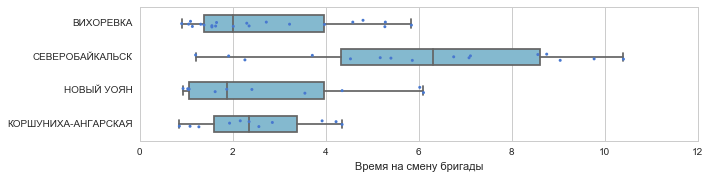

In [27]:
often_changes = team_change[team_change.st_to_name.isin(st_change)].copy()
often_changes['num'] = often_changes.st_to_name.map(a)
often_changes = often_changes.sort_values('num', ascending=False)
add_header('Среднее время на смену бригады на станциях с большим количеством смен:')
add_line(often_changes.groupby('st_to_name').stop_time_h.mean().sort_values(ascending=False).head(10))
sns.set(style='whitegrid', context='notebook', palette='muted', color_codes=True)
plt.figure(figsize=(10, .6 * len(st_change)))
sns.boxplot(x='stop_time_h', y='st_to_name', data=often_changes, whis=np.inf, color='c', width=0.5)
sns.stripplot(x='stop_time_h', y='st_to_name', data=often_changes, jitter=True, size=3, color='b')
plt.xlabel('Время на смену бригады')
plt.ylabel('')

In [28]:
cols = ['train', 'st_from_name', 'st_to_name', 'team', 'next_team', 'stop_time_h']
long_change = team_change[team_change.stop_time > MAX_TEAM_STOP].sort_values('stop_time', ascending=False)[cols]
if not long_change.empty:
    add_header('Всего %d случаев смены бригад с длительной стоянкой. Примеры:' % long_change.train.count())
    add_line(long_change[cols].head(20))
    add_line('')
    cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'team']
    add_header('Полный план по одному из таких поездов:')
    for train in long_change.train.values[:1]:
        add_line(train_plan[train_plan.train == train][cols])
    add_line('')
    add_header('Станции, на которых чаще всего происходили длительные стоянки на смену бригад:')
    add_line(long_change.st_to_name.value_counts().head(10))
else:
    add_header('Нет поездов, у которых смена бригады происходит более 6 часов')

Всего 37 случаев смены бригад с длительной стоянкой. Примеры:
   train st_from_name       st_to_name     team next_team  stop_time_h
 1002701   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032021   9271008        10.40
 1002725   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032418   9271020         9.77
 1002621   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032036   9032031         9.04
 1002729   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032026   9271017         8.75
 1002711   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032050   9032030         8.56
 1002603   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9044002   9032011         7.11
 1002703   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032013   9271908         7.08
 1002721   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032014   9271009         6.75
 1002721    АНГАРАКАН       НОВЫЙ УОЯН  9044011   9032014         6.10
 1002703    АНГАРАКАН       НОВЫЙ УОЯН  9044010   9032013         6.02
 1002615   НОВЫЙ УОЯН  СЕВЕРОБАЙКАЛЬСК  9032025   9032420         5.86
 1002114        ТУРМА        ВИХОРЕВКА  9244003   9244015         5.84
 1002601   НОВЫ

In [29]:
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'train']
loco_plan[loco_plan.loco == '2000102'][cols]

,loco,st_from_name,st_to_name,time_start_f,time_end_f,state,train
1587,2000102,ТАЙШЕТ,ТОРЕЯ,29/07 23:25,30/07 03:28,1,1002102
1588,2000102,ТОРЕЯ,ТУРМА,30/07 03:28,30/07 04:27,1,1002102
1589,2000102,ТУРМА,ВИХОРЕВКА,30/07 04:27,30/07 04:57,1,1002102
1590,2000102,ВИХОРЕВКА,МОРГУДОН,30/07 06:20,30/07 06:39,1,1002102
1591,2000102,МОРГУДОН,ГАЛАЧИНСКИЙ,30/07 06:39,30/07 07:35,1,1002102
1592,2000102,ГАЛАЧИНСКИЙ,ПАДУНСКИЕ ПОРОГИ,30/07 07:35,30/07 08:00,1,1002102
1593,2000102,ПАДУНСКИЕ ПОРОГИ,ГИДРОСТРОИТЕЛЬ,30/07 08:00,30/07 08:15,1,1002102
1594,2000102,ГИДРОСТРОИТЕЛЬ,КОРШУНИХА-АНГАРСКАЯ,30/07 08:15,30/07 12:14,1,1002102
1595,2000102,КОРШУНИХА-АНГАРСКАЯ,ХРЕБТОВАЯ,30/07 14:00,30/07 14:41,0,88880000074674
1596,2000102,ХРЕБТОВАЯ,ЛЕНА,30/07 14:41,30/07 17:13,0,88880000074674


In [30]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
print(team_plan[team_plan.team == '9244012'][cols].to_string(index=False))

    team         st_from_name           st_to_name time_start_f   time_end_f  state     loco
 9244012            ВИХОРЕВКА             МОРГУДОН  30/07 00:20  30/07 00:39      1  2000112
 9244012             МОРГУДОН          ГАЛАЧИНСКИЙ  30/07 00:39  30/07 01:00      1  2000112
 9244012          ГАЛАЧИНСКИЙ     ПАДУНСКИЕ ПОРОГИ  30/07 01:00  30/07 01:25      1  2000112
 9244012     ПАДУНСКИЕ ПОРОГИ       ГИДРОСТРОИТЕЛЬ  30/07 01:25  30/07 01:40      1  2000112
 9244012       ГИДРОСТРОИТЕЛЬ  КОРШУНИХА-АНГАРСКАЯ  30/07 01:40  30/07 05:39      1  2000112
 9244012  КОРШУНИХА-АНГАРСКАЯ  КОРШУНИХА-АНГАРСКАЯ  30/07 06:09  30/07 09:09      4       -1
 9244012  КОРШУНИХА-АНГАРСКАЯ  КОРШУНИХА-АНГАРСКАЯ  30/07 10:53  30/07 12:40      2       -1
 9244012  КОРШУНИХА-АНГАРСКАЯ       ГИДРОСТРОИТЕЛЬ  30/07 12:40  30/07 16:38      1  2000114
 9244012       ГИДРОСТРОИТЕЛЬ     ПАДУНСКИЕ ПОРОГИ  30/07 16:38  30/07 17:18      1  2000114
 9244012     ПАДУНСКИЕ ПОРОГИ          ГАЛАЧИНСКИЙ  30/07 17:18  30/07

In [31]:
cols = ['train', 'st_from_name', 'st_to_name', 'prev_end_f', 'time_start_f', 'time_end_f']
train_plan['prev_end_f'] = train_plan.time_end_f.shift(1)
train_plan['train_start'] = train_plan.train != train_plan.train.shift(1)
train_plan.loc[train_plan.train_start == True, 'prev_end_f'] = ''
train_plan[(train_plan.st_from_name == 'ВИХОРЕВКА') & (train_plan.st_to_name == 'МОРГУДОН')].sort_values('time_start')[cols]

,train,st_from_name,st_to_name,prev_end_f,time_start_f,time_end_f
1559,1002212,ВИХОРЕВКА,МОРГУДОН,,29/07 14:00,29/07 14:19
1509,1002214,ВИХОРЕВКА,МОРГУДОН,,29/07 15:10,29/07 15:29
1465,1002216,ВИХОРЕВКА,МОРГУДОН,,29/07 16:54,29/07 17:13
1247,1002206,ВИХОРЕВКА,МОРГУДОН,,29/07 18:25,29/07 18:44
1276,1002204,ВИХОРЕВКА,МОРГУДОН,,29/07 20:25,29/07 20:44
1286,1002202,ВИХОРЕВКА,МОРГУДОН,,29/07 22:40,29/07 22:59
932,1002112,ВИХОРЕВКА,МОРГУДОН,29/07 19:03,30/07 00:20,30/07 00:39
906,1002114,ВИХОРЕВКА,МОРГУДОН,29/07 20:04,30/07 01:55,30/07 02:14
880,1002118,ВИХОРЕВКА,МОРГУДОН,29/07 22:20,30/07 02:55,30/07 03:14
1375,1002222,ВИХОРЕВКА,МОРГУДОН,,30/07 03:35,30/07 03:54


In [32]:
slot = pd.read_csv(FOLDER + 'slot.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot)
cols = ['slot', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f']
slot[(slot.st_from_name == 'ВИХОРЕВКА') 
     & (slot.st_to_name == 'МОРГУДОН')].sort_values('time_start')[cols].drop_duplicates('time_start_f').head(50)

,slot,st_from_name,st_to_name,time_start_f,time_end_f
9047,200253963646,ВИХОРЕВКА,МОРГУДОН,29/07 05:09,29/07 05:28
14294,200253983857,ВИХОРЕВКА,МОРГУДОН,29/07 05:28,29/07 05:47
12718,200253973698,ВИХОРЕВКА,МОРГУДОН,29/07 06:21,29/07 06:40
19634,200254013731,ВИХОРЕВКА,МОРГУДОН,29/07 07:00,29/07 07:19
11975,200253983918,ВИХОРЕВКА,МОРГУДОН,29/07 07:13,29/07 07:32
14621,200253993863,ВИХОРЕВКА,МОРГУДОН,29/07 08:00,29/07 08:19
15028,200253993915,ВИХОРЕВКА,МОРГУДОН,29/07 09:16,29/07 09:35
15319,200253993961,ВИХОРЕВКА,МОРГУДОН,29/07 10:14,29/07 10:33
16552,200254003821,ВИХОРЕВКА,МОРГУДОН,29/07 11:17,29/07 11:36
17238,200254003902,ВИХОРЕВКА,МОРГУДОН,29/07 11:43,29/07 12:02


<a id='dep_interval'></a>
## Поиск поездов с интервалом между отправлениями меньше допустимого [ToC](#toc)

Между отправлениями двух поездов с одной станции в одном направлении должно быть не менее какого-то критического времени (сейчас оно установлено в 5 минут). Исключение может делаться только для локомотивов резервом (они могут планироваться и в одно и то же время).

In [33]:
add_header('Поиск поездов с интервалом между отправлениями меньше допустимого', h=2, p=False)

In [34]:
# Параметры

hor = 24 * 3600
min_time_delta = 5 * 60 # 5 minutes

In [35]:
# Функция, которая возвращает датафрейм с коллизиями

def check_time_collision(df):
    df['link_end'] = (df.st_from != df.st_from.shift(-1)) | (df.st_to != df.st_to.shift(-1))
    df['link_start'] = (df.st_from != df.st_from.shift(1)) | (df.st_to != df.st_to.shift(1))
    df.loc[df.link_end == False, 'time_to_next'] = df.time_start.shift(-1) - df.time_start
    df.loc[df.link_start == False, 'time_to_prev'] = df.time_start - df.time_start.shift(1)
    collisions = df.loc[(df.time_to_next < min_time_delta) | (df.time_to_prev < min_time_delta)]
    return collisions

In [36]:
add_line('Время начала планирования: %s' % nice_time(current_time))
cols = ['train', 'loco', 'team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f']
train_plan['train_start'] = train_plan.train != train_plan.train.shift(1)
train_plan.loc[train_plan.stop_time != -1, 'loco_start'] = (train_plan.loco != train_plan.loco.shift(1)) | \
                                                            (train_plan.train_start)
train_plan.loc[train_plan.stop_time != -1, 'team_start'] = train_plan.team != train_plan.team.shift(1)
mask = ((train_plan.loco_start == True) | (train_plan.team_start == True)) &\
        (train_plan.time_start < current_time + hor) & (train_plan.time_start >= current_time)
assign_mask = (train_plan.loco != '-1') & (train_plan.team != '-1')
cols_to_sort = ['st_from_name', 'st_to_name', 'time_start']
start_times = train_plan.loc[mask].sort_values(cols_to_sort)
start_times_no_res = train_plan.loc[mask & (train_plan.train_type.isin(['2', '9']))].sort_values(cols_to_sort)
start_times_real = train_plan.loc[mask & (train_plan.train_type == '2')].sort_values(cols_to_sort)
start_times_assign = train_plan.loc[mask & assign_mask].sort_values(cols_to_sort)
start_times_assign_no_res = train_plan.loc[mask & assign_mask &
                                           (train_plan.train_type.isin(['2', '9']))].sort_values(cols_to_sort)
start_times_assign_real = train_plan.loc[mask & assign_mask & (train_plan.train_type == '2')].sort_values(cols_to_sort)

all_coll = check_time_collision(start_times)
no_res_coll = check_time_collision(start_times_no_res)
real_coll = check_time_collision(start_times_real)
all_assign_coll = check_time_collision(start_times_assign)
no_res_assign_coll = check_time_collision(start_times_assign_no_res)
real_assign_coll = check_time_collision(start_times_assign_real)
train_n = len(start_times.train.drop_duplicates().index)
res = pd.DataFrame([['Все поезда', 'Без учета резервных', 'Без учета резервных и фейковых'],                    
                    [len(all_coll.index), len(no_res_coll.index), len(real_coll.index)],                    
                    [len(all_assign_coll.index), len(no_res_assign_coll.index), len(real_assign_coll.index)]]).T
res.columns = ['Тип', 'Из всех поездов', 'Из всех с подвязкой']
add_header('Количество коллизий (интервал между поездами меньше %d минут):' % (min_time_delta / 60))
add_line(res)
add_header('\nРеальные и фейковые поезда с интервалами меньше %d минут (первые 20):' % (min_time_delta / 60))
add_line(no_res_coll[cols].head(20))

Время начала планирования: 29/07 18:00
Количество коллизий (интервал между поездами меньше 5 минут):
                            Тип Из всех поездов Из всех с подвязкой
                     Все поезда               4                   4
            Без учета резервных               0                   0
 Без учета резервных и фейковых               0                   0

Реальные и фейковые поезда с интервалами меньше 5 минут (первые 20):
Empty DataFrame
Columns: [train, loco, team, st_from_name, st_to_name, time_start_f, time_end_f]
Index: []


<a id='ssp'></a>
## Сравнение количества запланированных поездов с данными АС ССП [ToC](#toc)

В файлах `SSP_KRS.csv` (и похожих - по другим дорогам) хранятся количества поездов, которые (в среднем) надо отправить с определенных стацниях в сутки. Это количество может меняться от суток к суткам (в зависимости от поездной обстановки в конкретный день), но примерную оценку по имеющимся данным сделать можно. Тест парсит файлы, берет оттуда необходимые направления и количества поездов, затем вычисляет запланированное количество по результатам планировщика и сравнивает.

In [37]:
add_header('Сравнение количества запланированных поездов с данными АС ССП', h=2, p=False)

In [38]:
# Функция достает требуемые количества из датафрейма, полученного из файла, считает количество поездов в плане и возвращает
# объединенный датафрейм с запланированным и требуемым количеством.

def count_volumes(full_plan, df_ssp):
    hor = 24 * 3600
    df_ssp.dep_dir.fillna(0, inplace=True)    
    df_ssp.loc[df_ssp.dep_dir == 0, 'depart'] = 0
    df_ssp.dropna(subset=['depart'], inplace=True)
    
    ssp_st_froms = df_ssp.loc[df_ssp.dep_dir == 0].station
    mask_time = (full_plan.time_start >= current_time) & (full_plan.time_start < current_time + hor)
    mask_type = full_plan.train_type.isin(['2', '9'])
    trains = full_plan.loc[mask_time & mask_type & full_plan.st_from_name.isin(ssp_st_froms)].\
                        groupby(['st_from_name', 'st_to_name']).train.count()
    df_ssp.loc[df_ssp.dep_dir == 0, 'st_from_name'] = df_ssp.station
    df_ssp = df_ssp.fillna(method='ffill')
    df_ssp['st_to_name'] = df_ssp.station
    replace_st_from_names = df_ssp.loc[df_ssp.dep_dir == 0, ['st_from_name', 'st_show_name']].drop_duplicates()
    df_ssp['st_from_show'] = df_ssp.st_from_name.map(replace_st_from_names.set_index('st_from_name').st_show_name)
    df_ssp['st_to_show'] = df_ssp.st_show_name    
    return trains.to_frame().join(df_ssp[['st_from_name', 'st_to_name', 'depart', 'st_from_show', 'st_to_show', 'dep_dir']].\
                    set_index(['st_from_name', 'st_to_name'])).reset_index() if not trains.empty else pd.DataFrame()

In [39]:
# Эта и следующая функция нужны только для показа графиков. Сейчас они не используются, для анализа, в общем, достаточно табличек

def show_barplot(df, road_name):
    df['delta'] = df.train - df.depart
    df['percent'] = np.round(100 * df.delta / df.depart, 2)
    df['st_from_short'] = df.st_from_show.apply(lambda x: str(x)[:25])
    df['st_to_short'] = df.st_to_show.apply(lambda x: str(x)[:25])
    df['link'] = df.st_from_short + ' - ' + df.st_to_short 
    
    print('%s железная дорога:' % road_name)
    print('Среднее и медиана абсолютного отклонения: %.2f, %.2f' % (df.delta.mean(), df.delta.median()))
    print('Среднее и медиана относительного отклонения (в процентах): %.2f%%, %.2f%%' % (df.percent.mean(), df.percent.median()))

    b = df.sort_values('delta', ascending=False)
    sns.set_style('whitegrid')
    sns.set_context('poster', font_scale=0.7, rc={'axes.labelsize': 18})
    c = sns.barplot(y='link', x='delta', data=df.sort_values('delta', ascending=False), palette='coolwarm')
    xlabel = '%s ж/д: отклонение от данных АС ССП по отправлению поездов на сутки' % road_name
    c.set(xlabel=xlabel, ylabel='')

In [40]:
VOL_PERCENT = 0.9

def show_two_barplots(df, road_name, save=False, btype='less'):
    df['st_from_short'] = df.st_from_show.apply(lambda x: str(x)[:25])
    df['st_to_short'] = df.st_to_show.apply(lambda x: str(x)[:25])
    df['link'] = df.st_from_short + ' - ' + df.st_to_short     
    sns.set_style('whitegrid')    
    sns.set_context('poster', font_scale=0.7, rc={'axes.titlesize':18, 'axes.labelsize':14})
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,20))    
    df.depart.fillna(0, inplace=True)    
    df['bottom'] = df.apply(lambda row: row.depart if row.train <= row.depart else row.train, axis=1)
    df['top'] = df.apply(lambda row: row.train if row.train <= row.depart else row.depart, axis=1)     
    
    sns.set_color_codes('pastel')
    sns.barplot(x='bottom', y='link', data=df[df.train <= VOL_PERCENT * df.depart].sort_values('bottom'), 
                label='Поезда из АС ССП', color="b", orient='h', ax=ax[0])
    sns.barplot(x='bottom', y='link', data=df[df.train * VOL_PERCENT > df.depart].sort_values('bottom'), 
                label='Поезда в результатах', color="r", orient='h', ax=ax[1])
    sns.set_color_codes('muted')
    sns.barplot(x='top', y='link', data=df[df.train <= VOL_PERCENT * df.depart].sort_values('bottom'), 
                label='Поезда в результатах', color="b", orient='h', ax=ax[0])
    sns.barplot(x='top', y='link', data=df[df.train * VOL_PERCENT > df.depart].sort_values('bottom'), 
                label='Поезда из АС ССП', color="r", orient='h', ax=ax[1])    
    ax[0].legend(ncol=1, loc="upper right", frameon=True)    
    ax[1].legend(ncol=1, loc="upper right", frameon=True)
    ax[0].set(xlabel='', title='Нехватка запланированных поездов')
    ax[1].set(xlabel='', title='Избыток запланированных поездов')
    
    sns.despine()
    if save:
        filename = road_name + '.png'
        fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
        add_image(filename, scale=1.0)

In [41]:
def func(x):
    return np.round(np.sqrt(np.mean(x ** 2)), 2)

def print_ssp_stats(ssp, road_name):
    df = count_volumes(train_plan, ssp)
    if not df.empty:
        df.rename(columns={'train':'planned', 'depart':'ssp'}, inplace=True)
        df.dropna(subset=['ssp'], inplace=True)
        df['delta'] = df.planned - df.ssp    
        cols = ['st_from_name', 'st_to_show', 'dep_dir', 'planned', 'ssp', 'delta']            
        add_header('Сравнение запланированного и "нормативного" количества поездов:')
        add_line(df.sort_values(['dep_dir', 'delta'])[cols])    
        add_header('\nСреднее отклонение по количеству поездов по направлениям:')
        add_line(df.groupby('dep_dir').delta.mean().apply(lambda x: np.round(x, 2)))
        add_header('\nСреднеквадратичное отклонение по направлениям:')
        add_line(df.groupby('dep_dir').delta.agg(func))
    else:
        add_header('Дорога %s' % road_name, h=3)
        add_line('Ни одного поезда не запланировано')

In [42]:
krs = pd.read_csv(FOLDER + 'mandatory/SSP_KRS.csv', sep=';')
vsib = pd.read_csv(FOLDER + 'mandatory/SSP_VSIB.csv', sep=';')
zab = pd.read_csv(FOLDER + 'mandatory/SSP_ZAB.csv', sep=';')
dvs = pd.read_csv(FOLDER + 'mandatory/SSP_DVS.csv', sep=';')

In [43]:
print_ssp_stats(krs, 'КРАС')

Дорога КРАС
Ни одного поезда не запланировано


In [44]:
print_ssp_stats(vsib, 'ВСИБ')

Дорога ВСИБ
Ни одного поезда не запланировано


In [45]:
print_ssp_stats(zab, 'ЗАБ')

Дорога ЗАБ
Ни одного поезда не запланировано


In [46]:
print_ssp_stats(dvs, 'ДВС')

Дорога ДВС
Ни одного поезда не запланировано


In [47]:
# Пример построения barplot

#krs = pd.read_csv(FOLDER + 'mandatory/SSP_KRS.csv', sep=';')
#add_header('Красноярская дорога')
#try:
#    show_two_barplots(count_volumes(train_plan, krs), 'Красноярская', save=True, btype='less')
#except:
#    add_line('Красноярская дорога: ошибка в построении графика')

<a id='info_plan_depart'></a>
## Проверка соответствия первого участка в запланированном маршруте и исходного факта [ToC](#toc)

Если поезд на начало планирования находится на каком-то перегоне (сообщение `train_depart`), то первый участок запланированного маршрута должен совпадать с участком местоположения поезда из входных данных.

**TODO: Можно обернуть строки показа результатов в if-then-else, чтобы не выводились пустые датафреймы, а писалось красивое сообщение, что ошибок нет.**

In [48]:
add_header('Проверка соответствия первого участка в запланированном маршруте и исходного факта', h=2, p=False)

In [49]:
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'st_from_name_info', 'st_to_name_info', 'oper_time_f']
td_plan = train_plan[(train_plan.st_from_info.isnull() == False) 
                     & (train_plan.st_from_info != '-1')].drop_duplicates('train')
td_bad_track = td_plan[(td_plan.st_from != td_plan.st_from_info) | (td_plan.st_to != td_plan.st_to_info)]
add_header('Поезда, у которых первый участок в маршруте не совпадает с исходным (всего %d, показаны первые 10):' 
          % td_bad_track.train.count())
add_line(td_bad_track[cols])

td_bad_time = td_plan[(td_plan.time_start != td_plan.oper_time)]
add_header('\nПоезда, у которых время отправления на первый участок в маршруте не совпадает с фактическим (всего %d, показаны первые 10):' 
          % td_bad_time.train.count())
pd.set_option('display.max_colwidth', 19)
add_line(td_bad_time.sort_values('oper_time')[cols].head(10))

Поезда, у которых первый участок в маршруте не совпадает с исходным (всего 0, показаны первые 10):
Empty DataFrame
Columns: [train, st_from_name, st_to_name, time_start_f, st_from_name_info, st_to_name_info, oper_time_f]
Index: []

Поезда, у которых время отправления на первый участок в маршруте не совпадает с фактическим (всего 0, показаны первые 10):
Empty DataFrame
Columns: [train, st_from_name, st_to_name, time_start_f, st_from_name_info, st_to_name_info, oper_time_f]
Index: []


<a id='time_leaps'></a>
## Проверка скачков по времени назад [ToC](#toc)

На запланированном маршруте поездов не должно быть случаев, когда время отправления с какой-то станции меньше времени прибытия на нее, а время прибытия на конечную станцию участка не больше времени отправления с начальной станции участка.

In [50]:
add_header('Проверка скачков по времени назад', h=2, p=False)

In [51]:
train_plan['next_time_start'] = train_plan.time_start.shift(-1)
train_plan['next_time_start_f'] = train_plan.time_start_f.shift(-1)
train_plan['train_end'] = train_plan.train != train_plan.train.shift(-1)
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'next_time_start_f']
leaps = train_plan[(train_plan.train_end == False) & (train_plan.next_time_start < train_plan.time_end)][cols]
if leaps.empty:
    add_header('Не найдено поездов со скачками по времени назад в плане')
else:
    add_header('Всего %d поездов со скачками по времени назад в плане. Примеры:' % leaps.drop_duplicates('train').train.count())
    add_line(leaps.drop_duplicates('train').head(10)[cols])
    train_id = leaps.drop_duplicates('train').iloc[0].train
    add_line('')    
    add_line(train_plan[train_plan.train == train_id][cols])

Не найдено поездов со скачками по времени назад в плане


<a id='irk_ssp'></a>

## Сравнение количества передаваемых в планировщик реальных поездов с ССП [ToC](#toc)

Детальное сравнение количества поездов для станции Иркутск.

1. Сначала производится приблизительное определение поездов, которые в ближайшие сутки должны проследовать через Иркутск. Для этого:
  1. Берутся поезда, у которых в маршруте есть Иркутск.
  2. Берется начальное местоположение поезда, определяется его время хода до Иркутска. Времена хода берутся из файла `travel_times.csv`.
  3. Добавляются допуски на стоянки для смены бригад. Считается, что смена бригады происходит каждые 6 часов и занимает примерно 1.5 часа. Поэтому время хода делится на 6 и умножается на 1.5 - так вычисляется добавка к "чистому" времени хода.
  4. Время хода и допуски прибавляются к времени последней операции (или к времени начала планирования - для поездов в состоянии `arrive` или `ready`, у которых время последней операции меньше времени начала планирования).
2. Затем оставляются только поезда, для которых время прибытия в Иркутск лежит в первых сутках планирования.
3. Затем определяются поезда (из п.1), которых вообще нет в результатах планирования. Это проблемные поезда, причины их отсутствия надо исследовать.
4. Затем для всех поездов определяется время прибытия в Иркутск. Если оно значительно отличается от предварительно рассчитанного (точного критерия ошибки тут нет - ориентировочно можно считать превышение на 3 часа значительным), то надо проверять, где этот поезд потерял время. 

In [52]:
# Направления для проверки

test = [('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ГОНЧАРОВО'), ('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'БАТАРЕЙНАЯ')]

In [53]:
add_header('Детальное сравнение количества поездов с данными ССП по станции %s' % test[0][0], h=2, p=False)

In [54]:
routes = pd.read_csv(FOLDER + 'routes.csv', dtype={'st_from':str, 'st_to':str, 'train':str})
add_info(routes)
routes['link_name'] = list(zip(routes.st_from_name, routes.st_to_name))
#def_tt = pd.read_csv(FOLDER + '/mandatory/travel_times_all_pairs.csv', sep=';').set_index(['st_from_name', 'st_to_name'])
def_tt = pd.read_csv(FOLDER + '/mandatory/travel_times.csv', index_col=0)

In [55]:
def get_arrive_time(row, station):
    if (row.oper == 'depart') | (row.oper_time >= current_time):
        start_time = row.oper_time
    else:
        start_time = current_time            
    return start_time + row.tt + row.lag

(test_st, test_st_dir) = test[0]
train_info['st_loc_name'] = train_info.oper_location.map(st_names.name)
train_info.st_loc_name.fillna(train_info.st_from_name, inplace=True)
#train_info['tt'] = train_info.st_loc_name.apply(lambda x: def_tt.ix[x, test_st].tt)
train_info['tt'] = train_info.st_loc_name.apply(lambda x: 48 * 3600 if type(x) == float else def_tt[x][test_st])

train_info['lag'] = np.round((train_info.tt / 6) * 1.5)
train_info['arr_time'] = train_info[['oper', 'oper_time', 'tt', 'lag']]\
                                    .apply(lambda row: get_arrive_time(row, test_st), axis=1)
train_info['arr_time_f'] = train_info.arr_time.apply(nice_time)
train_info['plan_time'] = train_info.train.map(train_plan[train_plan.st_from_name == test_st].set_index('train').time_start)
train_info['plan_time_f'] = train_info.plan_time.apply(nice_time)
train_info['delta'] = train_info.plan_time - train_info.arr_time
train_info['delta_h'] = np.round((train_info.delta / 3600), 2)

train_plan['link_name'] = list(zip(train_plan.st_from_name, train_plan.st_to_name))

dir_trains = train_info[(train_info.number >= 1000)
                        & (train_info.train.isin(routes[routes.link_name == (test_st, test_st_dir)].train))]
cols = ['train', 'number', 'oper', 'st_loc_name', 'tt', 'lag', 'oper_time_f', 'arr_time_f', 'plan_time_f', 'delta_h']
dir_trains = dir_trains[dir_trains.arr_time < current_time + 24 * 3600].sort_values('arr_time')
#a[cols]
add_header('Всего %d поездов, по которым ожидается проследование в направлении %s - %s в первые сутки планирования'
           % (dir_trains.train.count(), test_st, test_st_dir))

Всего 0 поездов, по которым ожидается проследование в направлении ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО в первые сутки планирования


In [56]:
no_plan = dir_trains[dir_trains.plan_time.isnull()][cols]
pd.set_option('display.max_colwidth', 40)
add_header('Всего %d поездов на направлении %s - %s, которых вообще нет в плане' % (no_plan.train.count(), test_st, test_st_dir))
add_line(no_plan)

Всего 0 поездов на направлении ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО, которых вообще нет в плане
Empty DataFrame
Columns: [train, number, oper, st_loc_name, tt, lag, oper_time_f, arr_time_f, plan_time_f, delta_h]
Index: []


In [57]:
plan_day = dir_trains[dir_trains.plan_time < current_time + 24 * 3600][cols]
add_header('Всего %d поездов (%.2f%%), по которым запланировано проследование в направлении %s - %s в первые сутки'
          % (plan_day.train.count(), 100 * plan_day.train.count() / dir_trains.train.count(), test_st, test_st_dir))

Всего 0 поездов (nan%), по которым запланировано проследование в направлении ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО в первые сутки


In [58]:
# sns.set(context='notebook', style='whitegrid')
# sns.set_color_codes('dark')
# plt.figure(figsize=(10, 5))
# sns.kdeplot(dir_trains[dir_trains.train.isin(plan_day.train) == False].dropna(subset=['delta']).delta / 3600, shade=True)

delta_lim = 3 * 3600
late_trains = dir_trains[dir_trains.delta > delta_lim]
late_trains.sort_values('delta', ascending=False)[cols]
add_header('Всего %d поездов (%.2f%%), у которых запланированное время проследования на участке %s - %s сильно сдвинуто вперед' 
           % (late_trains.train.count(), 100 * late_trains.train.count() / dir_trains.train.count(), test_st, test_st_dir))
add_line(late_trains.sort_values('delta', ascending=False)[cols])

Всего 0 поездов (nan%), у которых запланированное время проследования на участке ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО сильно сдвинуто вперед
Empty DataFrame
Columns: [train, number, oper, st_loc_name, tt, lag, oper_time_f, arr_time_f, plan_time_f, delta_h]
Index: []


In [59]:
plan_cols = ['train', 'oper', 'oper_time_f', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'team']
add_header('Пример плана по одному из поездов, формированием НЕ на станции %s:' % test_st)
#train_id = late_trains[late_trains.st_loc_name != test_st].sort_values('delta', ascending=False).iloc[0].train
train_id = '200022625675'
with pd.option_context('display.max_colwidth', 15):
    add_line(train_plan[train_plan.train == train_id][plan_cols])

Пример плана по одному из поездов, формированием НЕ на станции ИРКУТСК-СОРТИРОВОЧНЫЙ:
Empty DataFrame
Columns: [train, oper, oper_time_f, st_from_name, st_to_name, time_start_f, time_end_f, loco, team]
Index: []


In [60]:
slot = pd.read_csv(FOLDER + 'slot.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot)
slot['dt_start'] = slot.time_start.apply(datetime.datetime.fromtimestamp)

In [61]:
test = [('ТАЙШЕТ', 'ТОРЕЯ')]
(test_st, test_st_dir) = test[0]
plan_cols = ['train', 'st_from_name', 'st_to_name', 'dt_start', 'loco', 'team']
train_plan['dt_start'] = train_plan.time_start.apply(datetime.datetime.fromtimestamp)
a = train_plan[(train_plan.st_from_name == test_st) 
           & (train_plan.st_to_name == test_st_dir) & (train_plan.train_type.isin(['2', '9']))
           & (train_plan.time_start >= current_time) & (train_plan.time_end < current_time + 24 * 3600)]\
    .sort_values('dt_start')[plan_cols]
dep_volume = a.set_index('dt_start').resample('1H', how='count').train
dep_volume

Series([], Freq: H, Name: train, dtype: int64)

In [62]:
slot_volume = slot[(slot.st_from_name == test_st) & (slot.st_to_name == test_st_dir)]\
    .set_index('dt_start').resample('1H', how='count').slot
dep_slot = dep_volume.to_frame().join(slot_volume)

In [63]:
# slot_volume = slot[(slot.st_from_name == test_st) & (slot.st_to_name == test_st_dir)]\
#     .set_index('dt_start').resample('300s')
# slot_volume.dropna(subset=['slot'], inplace=True)
# slot_volume['slot'] = slot_volume.slot.apply(int)
# slot_volume = slot_volume.reset_index().set_index('slot')
# slot_volume

In [64]:
a = dep_slot[dep_slot.train > dep_slot.slot]
print(a)

Empty DataFrame
Columns: [train, slot]
Index: []


In [65]:
pd.set_option('display.max_colwidth', 40)
cols = ['train', 'st_from_name', 'st_to_name', 'dt_start']
for dt in a.index:
    dt_next = dt + datetime.timedelta(0, 3600, 0)
    print(dt, dt_next)
    print(train_plan[(train_plan.train_type.isin(['2', '9']))
                    & (train_plan.st_from_name == test_st) & (train_plan.st_to_name == test_st_dir)
                    & (train_plan.dt_start >= dt) & (train_plan.dt_start < dt_next)].sort_values('dt_start')[cols])
    print(slot[(slot.st_from_name == test_st) & (slot.st_to_name == test_st_dir)
                    & (slot.dt_start >= dt) & (slot.dt_start < dt_next)].sort_values('dt_start')[['slot', 'dt_start']])
    print('-------')

[В начало](#toc)
## Планирование сдвоенных поездов и поездов, составляющих сдвоенные

0. Сдвоенные поезда - это поезда, которые указаны в атрибуте `joint` у каких-либо других поездов.
1. Сдвоенные поезда с точки зрения планирования ничем не отличаются от обычных поездов. Проверяется, что сдвоенные поезда планируются до своей конечной станции.
2. Составляющие поезда должны планироваться от конечной станции сдвоенного поезда и только после прибытия сдвоенного поезда на конечную станцию.

In [66]:
add_header('Планирование сдвоенных поездов и поездов, составляющих сдвоенные', h=2, p=False)

In [67]:
train_info['is_arrive'] = train_info.last_st == train_info.loc_name
train_plan['last_st_info'] = train_plan.train.map(train_info.set_index('train').last_st)
joints = [t for t in train_info.joint.unique() if t != '-1']
info_joints = train_info[train_info.train.isin(joints)]
joints_to_plan = info_joints[info_joints.is_arrive == False]
joints_planned = train_plan[train_plan.train.isin(joints_to_plan.train)]
add_header('Всего запланировано %d сдвоенных поездов из %d корректно переданных (%.2f%%). Примеры незапланированных поездов:' 
           % (joints_planned.train.count(), joints_to_plan.train.count(), 
              100 * joints_planned.drop_duplicates('train').train.count() / joints_to_plan.train.count()))
cols = ['train', 'number', 'ind434', 'oper', 'oper_time_f', 'loc_name']
pd.set_option('display.max_colwidth', 50)
add_line(joints_to_plan.head(10)[cols])

Всего запланировано 0 сдвоенных поездов из 0 корректно переданных (nan%). Примеры незапланированных поездов:
Empty DataFrame
Columns: [train, number, ind434, oper, oper_time_f, loc_name]
Index: []


In [68]:
tl = joints_planned.drop_duplicates('train', keep='last')
tl_no_end = tl[tl.st_to_name != tl.last_st_info]
add_header('Всего %d сдвоенных поездов из %d запланированных (%.2f%%) запланированы НЕ до конца маршрута. Примеры:' 
           % (tl_no_end.train.count(), joints_planned.drop_duplicates('train').train.count(), 
              100 * tl_no_end.train.count() / joints_planned.drop_duplicates('train').train.count()))
cols = ['train', 'number', 'ind434', 'st_from_name', 'st_to_name', 'last_st_info']
add_line(tl_no_end.head(10)[cols])

Всего 0 сдвоенных поездов из 0 запланированных (nan%) запланированы НЕ до конца маршрута. Примеры:
Empty DataFrame
Columns: [train, number, ind434, st_from_name, st_to_name, last_st_info]
Index: []


In [69]:
inds = ['9300-248-9431', '9300-249-9700', '9300-573-9401', '9300-246-9431']
cols = ['train', 'ind434', 'number', 'oper', 'oper_time_f', 'loc_name']
train_info[train_info.ind434.isin(inds)][cols]

,train,ind434,number,oper,oper_time_f,loc_name


In [70]:
cols = ['train', 'ind434', 'oper', 'oper_time_f', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f']
train_plan[train_plan.ind434 == inds[3]][cols]

,train,ind434,oper,oper_time_f,st_from_name,st_to_name,time_start_f,time_end_f


In [71]:
train_info[train_info.ind434.apply(lambda x: '9300-246' in x)]
train_plan[train_plan.train == '200253661138'][cols]

,train,ind434,oper,oper_time_f,st_from_name,st_to_name,time_start_f,time_end_f


<a id='report'></a>
### Экспорт в HTML [ToC](#toc)

In [72]:
filename = REPORT_FOLDER + 'train_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/train_report_20160818_140539.html
